<a href="https://colab.research.google.com/github/kritinyoupane/Multi-Label-Text-Classification-with-Fully-Connected-NN/blob/main/Fully_ConnectedNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing necessary libraries

In [ ]:
import re
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import spacy
from nltk.stem import PorterStemmer
nlp = spacy.load('en_core_web_sm')

# Mounting Drive in Colab

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Data Preprocessing

#####Importing unclean dataset from drive

In [ ]:
# Reading the training and validation dataset
df_train = pd.read_csv('/content/gdrive/MyDrive/datarush/train.csv')
df_valid = pd.read_csv('/content/gdrive/MyDrive/datarush/validation.csv')

In [ ]:
df_train

,id,abstract,category,category_num
0,271675,Bacteria are often exposed to multiple stimu...,q-bio-QM,138
1,412276,Accurate knowledge of the thermodynamic prop...,hep-ph-,68
2,256956,The largest X9.3 solar flare in solar cycle ...,astro-ph-SR,7
3,427612,We say that a random integer variable $X$ is...,math-PR,93
4,113852,We derive a formula expressing the joint dis...,math-CO,76
...,...,...,...,...
390598,479582,Axion-like particles (ALPs) are hypothetical...,hep-ph-,68
390599,99488,Due to ever increasing usage of wireless dev...,eess-SP,62
390600,157301,Weight and activation binarization is an eff...,cs-CV,25
390601,209221,Large-scale unconstrained optimization is a ...,math-OC,92


In [ ]:
df_train.isna().sum()

id              0
abstract        0
category        0
category_num    0
dtype: int64

#####Cleaning the dataset

In [ ]:
ps = PorterStemmer()

In [ ]:
def clean_abstract(text):
  text = re.sub('[^a-z\s]', ' ', text.lower())
  text = [i.lower() for i in text.split() if i not in nlp.Defaults.stop_words]
  text = [ps.stem(i) for i in text]
  text = ' '.join(text)
  text.replace('\n',' ')
  return text

In [ ]:
df_train['abstract'] = df_train['abstract'].apply(clean_abstract)
df_valid['abstract'] = df_valid['abstract'].apply(clean_abstract)

#####Saving clean file in drive

In [ ]:
df_train.to_csv("clean_train.csv")
df_valid.to_csv("clean_valid.csv")

In [ ]:
!cp clean_train.csv "/content/gdrive/MyDrive/Amalgam/"
!cp clean_valid.csv "/content/gdrive/MyDrive/Amalgam/"

#####Importing clean datasets and checking if there is null values

In [ ]:
df_clean_train = pd.read_csv('/content/gdrive/MyDrive/Amalgam/clean_train.csv')
df_clean_valid = pd.read_csv('/content/gdrive/MyDrive/Amalgam/clean_valid.csv')

In [ ]:
#checking for null values
df_clean_train.isna().sum()

Unnamed: 0      0
id              0
abstract        1
category        0
category_num    0
dtype: int64

There is one null values after preprocessing

In [ ]:
df_clean_train.head()

,Unnamed: 0,id,abstract,category,category_num
0,0,271675,bacteria expos multipl stimuli complex environ...,q-bio-QM,138
1,1,412276,accur knowledg thermodynam properti zero tempe...,hep-ph-,68
2,2,256956,largest x solar flare solar cycl preced x flar...,astro-ph-SR,7
3,3,427612,random integ variabl x monoton modulu characte...,math-PR,93
4,4,113852,deriv formula express joint distribut cyclic v...,math-CO,76


In [ ]:
is_NaN = df_clean_train.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df_clean_train[row_has_NaN]
rows_with_NaN

,Unnamed: 0,id,abstract,category,category_num
112839,112839,59911,NaN,cs-LG,40


In [ ]:
#cleaning null value
df_clean_train.dropna(inplace=True)

In [ ]:
#checking if still null value is present
df_clean_train.isna().sum()

Unnamed: 0      0
id              0
abstract        0
category        0
category_num    0
dtype: int64

In [ ]:
df_clean_valid.isna().sum()

Unnamed: 0      0
id              0
abstract        0
category        0
category_num    0
dtype: int64

#### Text vectorization

In [ ]:
X_train, y_train = df_clean_train['abstract'],df_clean_train['category']
X_valid, y_valid = df_clean_valid['abstract'],df_clean_valid['category']

In [ ]:
uniqueValues = y_train.nunique()
print(uniqueValues)

156


There are 156 categories in train dataset

In [ ]:
uniqueValues = y_valid.nunique()
print(uniqueValues)

151


There are 151 categories in valid dataset

##### TfIDF

In [ ]:
tfidf = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1,1))

In [ ]:
tfidf_vectorizer = tfidf.fit(X_train)
tf_len = len(tfidf_vectorizer.vocabulary_)

X_train = tfidf_vectorizer.transform(X_train).astype('float32')
X_valid = tfidf_vectorizer.transform(X_valid).astype('float32')

#####Label Encoding

In [ ]:
label_encoder = LabelEncoder().fit(y_train)

y_train = label_encoder.transform(y_train)
y_valid = label_encoder.transform(y_valid)


### Classification using under sampling and over sampling

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
def sampling_strategy(y,n_samples, t='majority'):
    target_classes = ''
    if t == 'majority':
        target_classes = {k:v for k,v in dict(Counter(y)).items() if v > n_samples}
    elif t == 'minority':
        # Since SMOTE depends on KNN, filtering out those samples that occur less than 10 times
        target_classes = {k:v for k,v in dict(Counter(y)).items() if v < n_samples and v > 10}
    sampling_strategy = {k:n_samples for k,v in target_classes.items()}
    return sampling_strategy

In [ ]:
over_sampler_ss = sampling_strategy(y_train,1000,t='minority')

In [ ]:
under_sampler_ss = sampling_strategy(y_train,8000,t='majority')

In [ ]:
over = SMOTE(sampling_strategy=over_sampler_ss,random_state=42)

In [ ]:
under = RandomUnderSampler(sampling_strategy=under_sampler_ss, random_state=42)

In [ ]:
X_over, y_over = over.fit_resample(X_train, y_train)

In [ ]:
X_train_under, y_train_under = under.fit_resample(X_over, y_over)

###One Hot Encoding

In [ ]:
from keras.utils import np_utils
y_train_enc = np_utils.to_categorical(y_train_under)

In [ ]:
#Encoding validation dataset according to total number of categories in train dataset
n_classes = len(y_train_enc[0])
y_valid_enc = np_utils.to_categorical(y_valid, num_classes=n_classes)

In [ ]:
X_train_under.shape

(381961, 10000)

### Dense Neural Network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,BatchNormalization

In [ ]:
def build_model():
    model = Sequential()
    model.add(Dense(512, input_dim = X_train_under.shape[1], activation='relu',kernel_initializer= 'glorot_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # model.add(Dense(180, activation='relu'))
    # model.add(BatchNormalization())
    # model.add(Dropout(0.3))

    # model.add(Dense(128, activation='relu'))
    # model.add(BatchNormalization())
    # model.add(Dropout(0.3))

    model.add(Dense(n_classes, activation='softmax'))

    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
model = build_model()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               5120512   
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 256)              

In [ ]:
history = model.fit(X_train_under, y_train_enc, epochs=1, validation_data=(X_valid, y_valid_enc))#epochs 12

11937/11937 [==============================] - 822s 69ms/step - loss: 0.6883 - accuracy: 0.7861 - val_loss: 1.2662 - val_accuracy: 0.6619


###Training History Plot

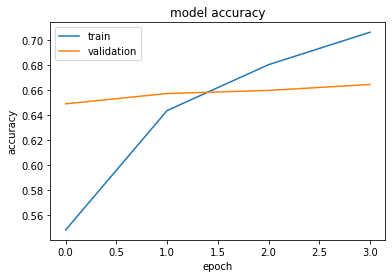

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

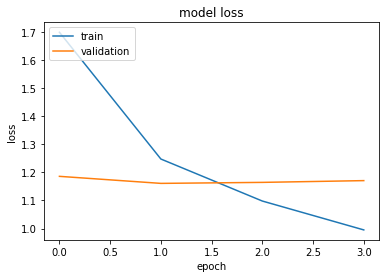

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

###Calculating F1 Score in validation dataset

In [ ]:
from sklearn.metrics import f1_score
def calculate_f1_score(X_valid,y_valid):
  valid_classes = model.predict(X_valid, verbose=0)
  predictions = []
  for i in valid_classes:
      max = np.argmax(i)
      predictions.append(max)
  predictions= np.array(predictions)
  return f1_score(y_valid, predictions, average='micro')

In [ ]:
print('F1 Score : {}'.format(calculate_f1_score(X_valid,y_valid, average='micro')))

F1 Score : 0.6643044404391283


###Saving model in drive

In [ ]:
from keras.models import load_model
filename = "Dense_neural_networkimproved.h5"
model.save("/content/gdrive/MyDrive/Amalgam/"+ filename)

###Loading model from Drive

In [ ]:
new_model = load_model("/content/gdrive/MyDrive/Amalgam/" + filename)

###Making predictions in test dataset

In [ ]:
#importing test dataset and checking if there are null values
df_test = pd.read_csv('/content/gdrive/MyDrive/datarush/test.csv')
df_test['abstract'] = df_test['abstract'].apply(clean_abstract)
df_test.isna().sum()

In [ ]:
#Vectorizing the data
X_test = df_test['abstract']
X_test = tfidf_vectorizer.transform(X_test).astype('float32')

In [ ]:
#make prediction and store f1 score
test_classes = model.predict(X_test, verbose=0)
test_predictions = []
for i in test_classes:
    maxx = np.argmax(i)
    test_predictions.append(maxx)
test_predictions= np.array(test_predictions)
test_predictions

###Mapping predicted labels with category number

In [ ]:
#importing label.csv file
df_label = pd.read_csv('/content/gdrive/MyDrive/datarush/labels.csv')

In [ ]:
predicted_classes = []
for i in test_predictions:
    predicted_classes.append(label_encoder.classes_[i])

###Storing the solution file in drive

In [ ]:
solution_df = pd.DataFrame()
solution_df['id'] = df_test['id']
solution_df['category_num'] = pd.Series(test_predictions)

In [ ]:
solution_df.reset_index(drop=True, inplace=True)
solution_df.to_csv('solution.csv', index=False)

In [ ]:
!cp solutionimp.csv "/content/gdrive/MyDrive/Amalgam/"
